In [1]:
import numpy as np
import import_ipynb

import organizing
import loadMSIS
import loadIRI
import EnergyDissipation 
import loadEISCAT


'''
This is the main file. It is used to start the simulation.
Configuration files from IRI and MSIS models are specified here.
Eiscat data files are specified here.
'''

con = organizing.pcfg
con.disable()
print('Printing: ', con.print)

msis_config = '/Users/ost051/Documents/PhD/Electron Precipitation/example/Meta-data/msis.txt'
iri_config  = '/Users/ost051/Documents/PhD/Electron Precipitation/example/Meta-data/iri.txt'
chemistry_config = '/Users/ost051/Documents/PhD/Electron Precipitation/example/Meta-data/Reaction rates.txt'
path_eiscat_data = '/Users/ost051/Documents/PhD/Electron Precipitation/example/Data/'

setup_ = organizing.setup(msis_config, iri_config, chemistry_config, path_eiscat_data)
log_directory = setup_._log_directory

[z_msis
 , n_o1_msis
 , n_n2_msis
 , n_o2_msis
 , mass_density
 , temp_n_msis
 , scale_height_msis] = loadMSIS.loadMSIS(log_directory + '/Config/msis.txt')

[z_iri     
 , ne_iri    
 , t_neutral 
 , t_ion     
 , t_e       
 , rel_o_p   
 , rel_n_p   
 , rel_h_p   
 , rel_he_p  
 , rel_o2_p  
 , rel_no_p] = loadIRI.loadIRI(log_directory + '/Config/iri.txt')

importing Jupyter notebook from organizing.ipynb
importing Jupyter notebook from loadMSIS.ipynb
importing Jupyter notebook from loadIRI.ipynb
importing Jupyter notebook from EnergyDissipation.ipynb
importing Jupyter notebook from loadEISCAT.ipynb
Printing:  0


In [2]:
[z_radar_time
 , parameters
 , time
 , az
 , el
 , r_errors ] = loadEISCAT.loadEISCATdata(path_eiscat_data, ['r_h', 'r_param', 'r_time', 'r_az', 'r_el', 'r_error'])

z_radar = z_radar_time[0] #for static measurements, the information in r_h stays the same for all measurement points.
ne_meas = parameters[:, :, 0]
dne_meas = r_errors[:, :, 0]
vel = parameters[:, :, 4]
vel_err = r_errors[:, :, 4]

#conversion to SI units:
z_radar = z_radar*1e3
r_time = time[:,0,3]*3600 + time[:,0,4]*60 + time[:,0,5]

del parameters, r_errors, z_radar_time, az, el, time

In [3]:
#differential flux: energy binning: 
e_bin_lims = np.logspace(2, 2+3, 501)

#defining parameters for electron production model
inc_B = 0
z_min = 70000
z_max = 200000
res_model = 100
z_sd_min = 0
z_sd_max = 800e3
res_sd = 10

e_prod, z_model = EnergyDissipation.e_production(z_min
                                                 , z_max
                                                 , res_model
                                                 , z_sd_min
                                                 , z_sd_max
                                                 , res_sd
                                                 , e_bin_lims
                                                 , z_msis
                                                 , mass_density
                                                 , inc_B)

0.0
0.1
0.2
0.4
0.8


In [4]:
#setup of ion chemistry
import ionChem

model = ionChem.ionChem(chemistry_config, z_model)

model.assign_densities(z_model
                     , z_msis
                     , n_o1_msis
                     , n_n2_msis
                     , n_o2_msis
                     , z_iri
                     , ne_iri        
                     , rel_o_p   
                     , rel_n_p   
                     , rel_h_p   
                     , rel_he_p  
                     , rel_o2_p  
                     , rel_no_p)

model.check_chargeNeutrality()

importing Jupyter notebook from ionChem.ipynb


<string>:184: RuntimeWarning: divide by zero encountered in log
<string>:190: RuntimeWarning: divide by zero encountered in log


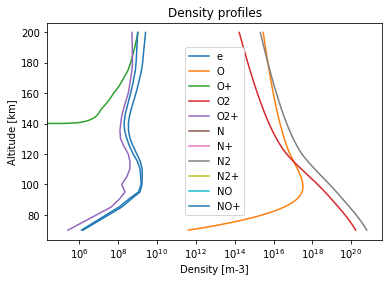

In [5]:
import matplotlib.pyplot as plt
plt.figure()
for c in model.all_species:
    plt.plot(c.density, z_model/1e3, label = c.name)
plt.xscale('log')
plt.xlabel('Density [m-3]')
plt.ylabel('Altitude [km]')
plt.title('Density profiles')
plt.legend()

In [21]:
import matplotlib.pyplot as plt
#%matplotlib widget

def plot_snapshot(model):
    plt.figure()
    for c in model.all_species:
        plt.plot(c.density, z_model/1e3, label = c.name)
    plt.xscale('log')
    plt.xlim(1e4, 1e10)
    plt.xlabel('Density [m-3]')
    plt.ylabel('Altitude [km]')
    plt.title('Density profiles')
    plt.legend()

In [7]:
setup_.datadump(model)
dt = 0.01
#con.enable()
for i in range(2000000):
    model.update_timestep(dt)
    #plot_snapshot(model)
    #if model.time%1 == 0: setup_.datadump(model)
    if model.iteration_step%100 == 0: 
        setup_.datadump(model)
    if model.iteration_steption_step%1000 == 0:
        print(model.time)
    
    

In [18]:
model.time/60/60

5.555555555481218

In [8]:
"""
check charge conservation!!
any other important things?
"""

'\ncheck charge conservation!!\nany other important things?\n'

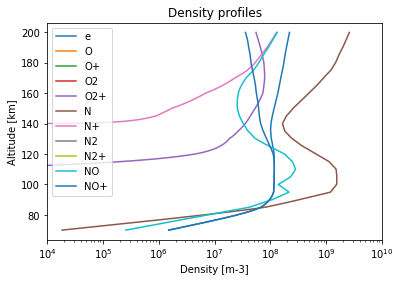

In [22]:
    plot_snapshot(model)

In [11]:
import pickle

def loadall(filename):
    with open(filename, "rb") as f:
        while True:
            try:
                yield pickle.load(f)
            except EOFError:
                break
                
data = list(loadall(log_directory + '/Simulation/log.p'))

data[1].all_species[3].density


array([1.71698197e+20, 1.69839209e+20, 1.67994923e+20, ...,
       1.72829477e+14, 1.71981854e+14, 1.71138687e+14])

In [12]:
time = np.array([i.time for i in data])
densities = np.array([[j.density for j in i.all_species] for i in data])

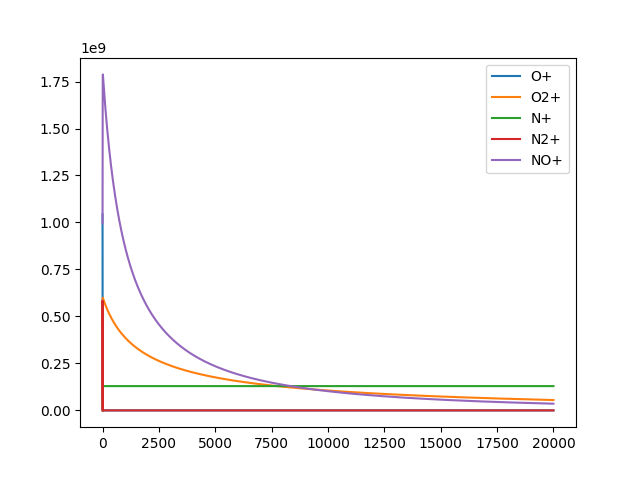

In [23]:
%matplotlib widget
plt.figure()
for c in data[0].ions:
    i = c.c_ID
    plt.plot(time, densities[:, i, -1], label=c.name)
#plt.yscale('log')
plt.legend()

In [16]:
#do some testing with ion chemistry, eg only recombinative processes and see how it evovles
#why do i have problmes with charge neutrality for larger timesteps?